In [26]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import gc
import copy
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime


from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K

In [4]:
csv_file_folder =  '../../data/input'
file_folder =  '../../data/feature'

In [5]:
submission = pd.read_csv(f'{csv_file_folder}/sample_submission.csv')

In [6]:
def create_nn_model(input_shape):
    dropout = .2
    inp = Input(shape=(input_shape,))
    x = Dense(2048, activation="relu")(inp)
    x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
    for i in range(2):
        x = Dense(1024, activation="relu")(x)
        x = BatchNormalization()(x)
#         x = Dropout(dropout)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
#     x = Dropout(dropout)(x)
    out = Dense(1, activation="linear")(x)  
   # out1 = Dense(2, activation="linear")(x)#mulliken charge 2
   # out2 = Dense(6, activation="linear")(x)#tensor 6(xx,yy,zz)
   # out3 = Dense(12, activation="linear")(x)#tensor 12(others) 
   # out4 = Dense(1, activation="linear")(x)#scalar_coupling_constant 
    #model = Model(inputs=inp, outputs=[out,out1,out2,out3,out4])
    model = Model(inputs=inp, outputs=[out])
    return model

In [7]:
def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [8]:
# Set up GPU preferences
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 2} ) 
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = tf.Session(config=config) 
K.set_session(sess)

In [9]:

type_columns = [['tertiary_angle_0', 'inv_dist1R', 'd_4_3', 'yukawa_H.y', 'mulliken_atom_0', 'dist_to_type_mean', 'dist_O_0_x', 'atom_1_n_bonds', 'dist_to_type_1_mean', 'atom_1_bond_lengths_mean', 'dist_xyz', 'dist_C_0_y', 'd_3_2', 'atom_index_1_ hybridization', 'atom_index_1_cycle_size_mean', 'dist_O_0_y', 'eem_1', 'inv_distPE', 'd_4_2', 'inv_distPR', 'dist_no_bond_min_y', 'dist_H_2_x', 'dist_H_1_x', 'tertiary_distance_2', 'dist_C_3_x', 'dist_O_1_x', 'atom_1_bond_lengths_std', 'dist_C_2_y', 'dist_C_2_x', 'mulliken_atom_1', 'cos_center1', 'dist_O_1_y', 'tertiary_angle_3', 'dist_H_2_y', 'dist_N_0_y', 'dist_C_1_y', 'inv_dist1E', 'distance_y', 'tertiary_angle_2', 'dist_N_0_x', 'd_2_1', 'molecule_atom_index_0_dist_max_div', 'adC1', 'adN1', 'd_4_0', 'dist_C_3_y', 'atom_3', 'distC0', 'tertiary_distance_4', 'tertiary_angle_5', 'd_5_1', 'molecule_atom_index_1_dist_min_diff', 'dist_C_4_y', 'dist_H_0_y', 'cos_f0', 'd_5_0', 'tertiary_distance_3', 'd_5_2', 'tertiary_atom_1', 'dist_C_4_x', 'cos_c0_f0', 'atom_index_0_sv_3', 'rc_C', 'cos_f1', 'tertiary_angle_8', 'dist_O_2_y', 'max_molecule_atom_1_dist_xyz', 'dist_F_0_y', 'atom_index_1_ aromatic', 'tertiary_angle_26', 'type_0'],
['dist_H_0_y', 'd_3_2', 'dist_C_0_y', 'atom_index_1_ aromatic', 'atom_1_bond_lengths_mean', 'bond_atom', 'inv_dist1R', 'd_3_1', 'mulliken_atom_0', 'dist_H_0_x', 'dist_O_0_y', 'dist_C_1_x', 'tertiary_angle_0', 'dist_C_1_y', 'vander_C.y', 'dist_H_1_y', 'mulliken_atom_1', 'inv_dist0R', 'd_1_0', 'tertiary_distance_0', 'tertiary_angle_2', 'atom_index_1_explicit_valence', 'dist_N_0_y', 'inv_distPR', 'dist_C_2_x', 'vander_H.x', 'd_4_2', 'atom_index_0_eigv_max', 'tertiary_distance_2', 'dist_H_1_x', 'dist_N_1_x', 'dist_C_3_x', 'cos_f0', 'atom_index_1_sv_2', 'max_molecule_atom_0_dist_xyz', 'd_2_1'],
['tertiary_atom_0', 'inv_dist0', 'dist_no_bond_min_x', 'atom_index_1_ hybridization', 'tertiary_angle_0', 'tertiary_angle_1', 'dist_O_0_x', 'cos_c0', 'd_5_2', 'tertiary_atom_1', 'cos_f0', 'dist_H_0_x', 'd_3_1', 'atom_index_1_degree', 'dist_C_0_y', 'adC2', 'dist_C_3_x', 'vander_O.y', 'mulliken_atom_1', 'atom_7', 'tertiary_angle_2', 'd_2_1', 'atom_3', 'd_5_1', 'd_6_2', 'd_4_1', 'tertiary_atom_2', 'molecule_atom_index_1_dist_min_diff', 'd_4_2', 'dist_C_2_x', 'cos_c0_f0', 'd_6_0', 'dist_O_0_y', 'd_4_3', 'd_3_0', 'd_7_0', 'd_3_2', 'inv_dist0R', 'atom_8', 'dist_C_1_x', 'd_6_1', 'd_2_0', 'd_8_1', 'mulliken_atom_0', 'dist_N_0_x', 'atom_4', 'tertiary_distance_2', 'd_7_2', 'dist_C_0_x', 'atom_1_bond_lengths_mean', 'dist_C_1_y', 'bond_atom', 'd_7_1', 'd_4_0', 'distC0', 'atom_index_1_cycle_size_mean', 'cos_c0_c1', 'tertiary_angle_3', 'dist_O_1_x', 'atom_index_1_n_cycle', 'max_molecule_atom_0_dist_xyz', 'molecule_atom_index_0_dist_max_div', 'atom_5', 'gap', 'cos_c1', 'dist_N_0_y', 'd_6_3', 'dist_C_3_y', 'inv_distP', 'dist_C_4_y'],
['cos_c0', 'd_4_3', 'cos_c0_c1', 'molecule_atom_index_0_dist_min_diff', 'tertiary_atom_1', 'd_3_2', 'd_1_0', 'dist_H_0_y', 'mulliken_atom_0', 'mulliken_atom_1', 'dist_N_0_x', 'link0', 'tertiary_atom_2', 'dist_C_1_y', 'dist_C_1_x', 'cos_f0', 'dist_C_0_y', 'cos_f1', 'd_3_1', 'tertiary_distance_1', 'dist_O_0_y', 'cos_f0_f1', 'adC1', 'd_5_3', 'inv_distP', 'edge_4', 'd_6_2', 'dist_N_0_y', 'tertiary_distance_2', 'dist_O_0_x', 'cos_c1_f1', 'd_3_0', 'd_5_2', 'dist_C_0_x', 'adN1', 'cos_c0_f0', 'd_4_1', 'max_distance_y', 'dist_C_2_y', 'atom_5', 'adC3', 'dist_to_type_1_mean', 'vander_H.x', 'dist_C_3_y', 'dist_H_3_x', 'molecule_atom_index_0_dist_max_div', 'atom_7', 'dist_C_3_x', 'd_5_1', 'dist_H_3_y', 'atom_index_0_eigv_max', 'atom_6', 'dist_H_2_x', 'atom_index_1_sv_0', 'molecule_atom_index_1_dist_std_div', 'link1'],
['d_3_1', 'dist_H_1_x', 'd_5_0', 'd_4_0', 'yukawa_H.x', 'inv_dist0', 'd_6_0', 'd_4_1', 'cos_c0', 'atom_3', 'dist_C_0_y', 'molecule_atom_index_0_dist_std_div', 'cos_c0_c1', 'd_4_2', 'min_molecule_atom_0_dist_xyz', 'sd_molecule_atom_0_dist_xyz', 'd_2_1', 'adC2', 'd_3_0', 'dist_C_1_y', 'd_4_3', 'dist_H_0_x', 'vander_C.x', 'd_5_3', 'dist_H_1_y', 'tertiary_distance_3', 'd_2_0', 'dist_O_0_x', 'd_5_1', 'dist_O_0_y', 'adC3', 'inv_dist0R', 'dist_C_3_y', 'atom_index_1_ hybridization', 'cos_f0', 'dist_C_2_x', 'd_5_2', 'd_6_1', 'dist_C_0_x', 'atom_1_bond_lengths_min', 'mulliken_atom_1', 'distance_farthest_0', 'tertiary_distance_1', 'min_molecule_atom_1_dist_xyz', 'yukawa_O.y', 'atom_0_bond_lengths_max'],
['tertiary_angle_0', 'd_2_1', 'cos_c0', 'atom_1_bond_lengths_mean', 'd_3_1', 'd_2_0', 'tertiary_distance_1', 'd_3_2', 'tertiary_angle_1', 'cos_f0', 'tertiary_distance_2', 'dist_C_0_x', 'dist_H_0_x', 'dist_C_2_x', 'dist_O_0_y', 'd_4_1', 'd_4_3', 'atom_index_1_cycle_size_mean', 'molecule_atom_index_0_dist_min_diff', 'tertiary_atom_2', 'atom_4', 'cos_c0_f0', 'tertiary_distance_3', 'd_3_0', 'dist_median_bond_y', 'd_5_2', 'adC3', 'atom_5', 'dist_H_1_x', 'molecule_atom_index_0_dist_min_div', 'gap', 'molecule_atom_index_1_dist_min_div', 'dist_O_0_x', 'cos_c1', 'dist_C_0_y', 'd_5_1', 'dist_N_0_y', 'dist_C_3_y', 'dist_no_bond_min_y', 'd_4_0', 'dist_N_0_x', 'd_4_2', 'max_molecule_atom_0_dist_xyz', 'cos_c0_c1', 'adC2', 'atom_index_1_n_cycle', 'd_5_0', 'd_6_1', 'dist_C_4_y', 'dist_O_1_y', 'd_7_2', 'tertiary_angle_2', 'd_6_2', 'mulliken_atom_1', 'atom_6', 'd_7_3', 'dist_O_1_x'],
['cos_c0_c1', 'atom_4', 'atom_5', 'molecule_atom_index_0_dist_min_diff', 'cos_c1', 'max_molecule_atom_1_dist_xyz', 'dist_to_type_std', 'd_3_2', 'cos_c0', 'dist_O_0_x', 'd_4_3', 'atom_6', 'dist_O_0_y', 'tertiary_atom_1', 'dist_C_2_y', 'd_4_2', 'dist_C_1_y', 'atom_7', 'tertiary_angle_1', 'dist_H_0_y', 'dist_no_bond_min_y', 'distance_c1', 'dist_C_2_x', 'linkM0', 'd_6_2', 'dist_C_0_y', 'd_5_2', 'd_7_2', 'dist_C_3_y', 'd_6_0', 'dihedral', 'max_molecule_atom_0_dist_xyz', 'd_7_3', 'd_6_1', 'dist_H_1_y', 'tertiary_atom_2', 'd_4_0', 'tertiary_atom_0', 'tertiary_angle_3', 'dist_C_0_x', 'dist_to_type_0_mean', 'dist_N_0_y', 'd_4_1', 'cos_c1_f1', 'cos_f0', 'dist_xyz', 'adC2', 'd_5_3', 'cos_f0_f1', 'gap', 'd_7_0', 'cos_f1', 'tertiary_distance_1', 'molecule_atom_index_0_dist_max_diff', 'd_2_1'],
['cos_c0', 'tertiary_distance_1', 'cos_c1', 'd_3_2', 'tertiary_angle_1', 'tertiary_angle_0', 'atom_1_n_bonds', 'tertiary_distance_2', 'd_2_1', 'tertiary_angle_2', 'd_4_0', 'molecule_atom_index_0_dist_min_div', 'd_2_0', 'dist_H_0_x', 'd_3_1', 'cos_c0_c1', 'mulliken_atom_1', 'd_8_3', 'd_4_1', 'dist_C_0_y', 'd_3_0', 'atom_index_1_cycle_size_mean', 'dist_C_1_x', 'dist_C_2_x', 'adC2', 'adC1', 'atom_1_bond_lengths_std', 'atom_index_1_n_cycle', 'd_4_2', 'cos_f0', 'd_5_2', 'dist_to_type_0_mean', 'dist_O_0_x', 'molecule_atom_index_0_dist_std_diff', 'd_5_1', 'tertiary_angle_3', 'd_6_2', 'd_7_3']]

In [10]:
unique_cols = []
for cols in type_columns:
    unique_cols += cols
unique_cols = list(set(unique_cols))

In [11]:
len(unique_cols)

153

In [12]:
plus_cols = pd.read_pickle(f'{file_folder}/df_train2_plus.gzde', compression='gzip').columns.tolist()

In [13]:
unique_cols_plus = [col for col in unique_cols if col in plus_cols]

In [14]:
unique_cols_data2 = list(set(unique_cols) - set(unique_cols_plus))

In [15]:
len(unique_cols_data2), len(unique_cols_plus)

(105, 48)

In [16]:
df_train2 = pd.read_pickle(f'{file_folder}/df_train2.gzde', compression='gzip')[['index', 'type', 'group', 'scalar_coupling_constant', 'fc', 'sd','pso','dso']+unique_cols_data2]
df_train2_plus = pd.read_pickle(f'{file_folder}/df_train2_plus.gzde', compression='gzip')[['id']+unique_cols_plus]
df_train2_plus = df_train2_plus.rename(columns={'id':'index'})
df_train2 = pd.merge(df_train2, df_train2_plus, how='left', on='index')
df_train2 = df_train2.fillna(0)

df_test2 = pd.read_pickle(f'{file_folder}/df_test2.gzde', compression='gzip')[['index', 'type', 'group']+unique_cols_data2]
df_test2_plus = pd.read_pickle(f'{file_folder}/df_test2_plus.gzde', compression='gzip')[['id']+unique_cols_plus]
df_test2_plus = df_test2_plus.rename(columns={'id':'index'})
df_test2 = pd.merge(df_test2, df_test2_plus, how='left', on='index')
df_test2 = df_test2.fillna(0)

In [17]:
oof_path = '../select_features'

In [22]:
# df_train = pd.DataFrame()
# df_test = pd.DataFrame()

# for f in [f for f in os.listdir(oof_path) if f.startswith('oof')][:]:
    
#     if 'train' in f:
#         df_i = pd.read_pickle(f'{oof_path}/{f}', compression='gzip')
#         df_train[f'{f}'.replace('_train', '')] = df_i.predict
#         if 'index' not in df_train.columns:
#             df_train['index'] = df_i['index']
        
#     if 'test' in f:
#         df_i = pd.read_pickle(f'{oof_path}/{f}', compression='gzip')
#         df_test[f'{f}'.replace('_test', '')] = df_i.drop(columns=['index']).mean(axis=1)
#         if 'index' not in df_test.columns:
#             df_test['index'] = df_i['index']

In [20]:
# df_train = pd.merge(df_train2[['index', 'type', 'group', 'scalar_coupling_constant', 'fc', 'sd','pso','dso']+unique_cols], df_train, how='left', on='index')
# df_train['y'] = df_train2['scalar_coupling_constant']
# df_test = pd.merge(df_test2[['index', 'type', 'group']+unique_cols], df_test, how='left', on='index')

In [21]:
df_train = df_train2[['index', 'type', 'group', 'scalar_coupling_constant', 'fc', 'sd','pso','dso']+unique_cols]
df_test = df_test2[['index', 'type', 'group']+unique_cols]

In [22]:
type_list = df_train.type.unique().tolist()
type_list

[0, 3, 1, 4, 2, 6, 5, 7]

In [24]:
retrain =True
cv_score=[]
cv_score_total=0
epoch_n = 1000
verbose = 0
batch_size = 2048

Training 0 out of [0, 3, 1, 4, 2, 6, 5, 7] 



W0825 06:35:04.101106 140436008154880 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 06:35:04.101931 140436008154880 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 06:35:04.103884 140436008154880 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 06:35:04.152518 140436008154880 deprecation_wrapper.py:119] From /root/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0


Epoch 00232: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00274: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00340: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00350: early stopping


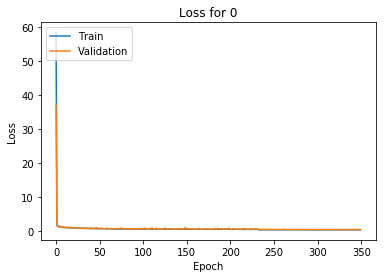

0-0 -0.7908991711619335

Epoch 00149: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00218: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00332: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00342: early stopping


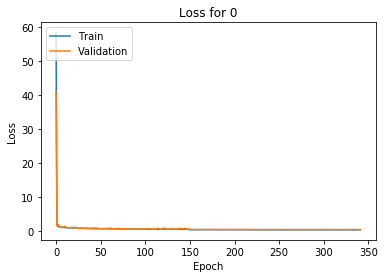

0-1 -0.7676027443938302

Epoch 00207: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00280: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Restoring model weights from the end of the best epoch
Epoch 00290: early stopping


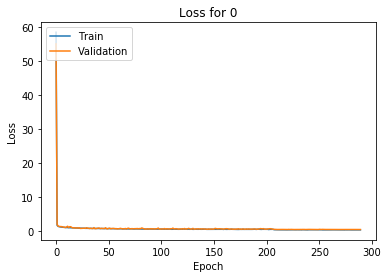

0-2 -0.7588682702358965

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00240: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00294: early stopping


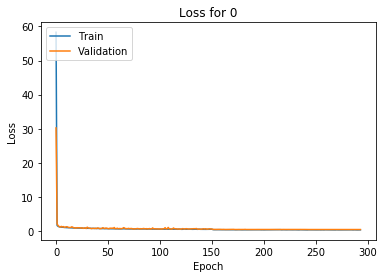

0-3 -0.7520657696968633

Epoch 00129: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00237: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00277: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00287: early stopping


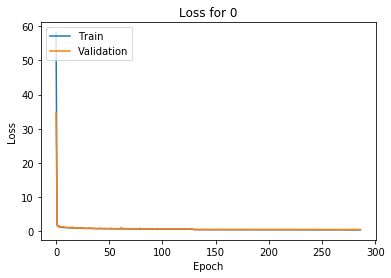

0-4 -0.7527866422334194

Epoch 00214: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00270: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00306: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00316: early stopping


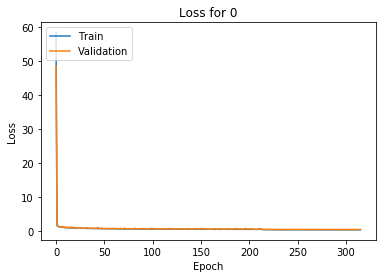

0-5 -0.770751800064173

Epoch 00160: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00258: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00310: early stopping


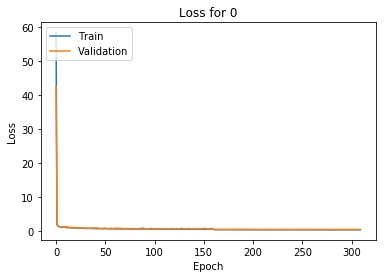

0-6 -0.7564884825176912

Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00186: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00241: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00295: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00305: early stopping


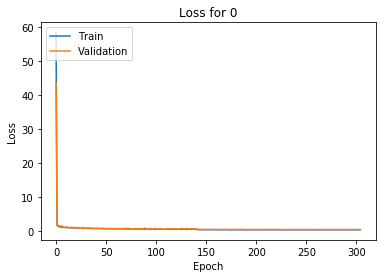

0-7 -0.7533232867437826
Training 3 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00128: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00170: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00224: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00269: early stopping


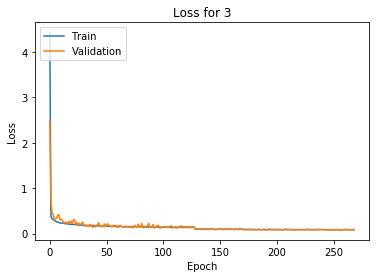

3-0 -2.4841857619549272

Epoch 00142: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00202: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00276: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00311: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00321: early stopping


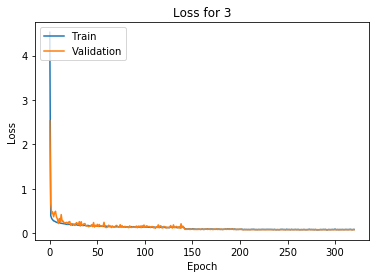

3-1 -2.498617756651024

Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00193: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00250: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00282: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00292: early stopping


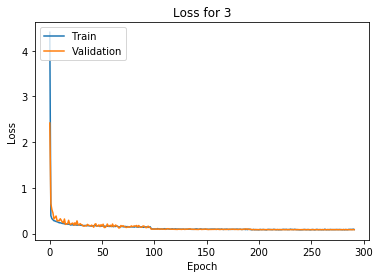

3-2 -2.4754836321789835

Epoch 00154: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00200: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00269: early stopping


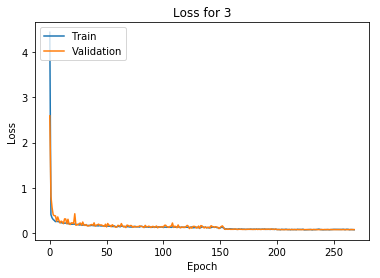

3-3 -2.4773251209684783

Epoch 00230: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00299: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00378: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00388: early stopping


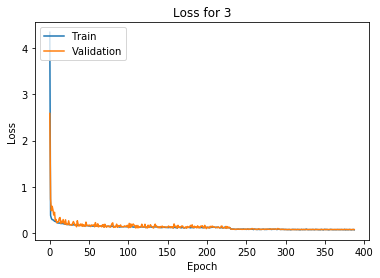

3-4 -2.500741107029889

Epoch 00171: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00265: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00359: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00369: early stopping


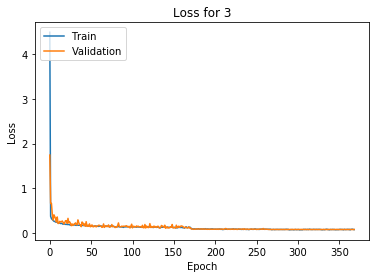

3-5 -2.4997589974267598

Epoch 00163: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00223: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00266: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00299: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00309: early stopping


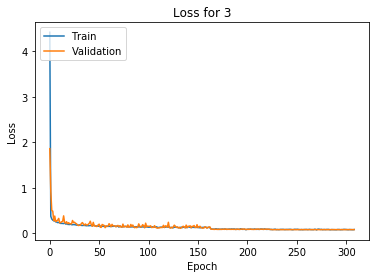

3-6 -2.500852384431933

Epoch 00196: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00304: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00341: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00351: early stopping


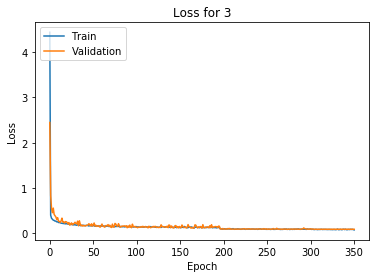

3-7 -2.4781311719754058
Training 1 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00131: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00259: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00321: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00331: early stopping


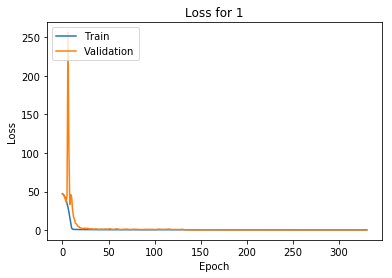

1-0 -1.324093949181821

Epoch 00100: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00191: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00229: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00331: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00372: early stopping


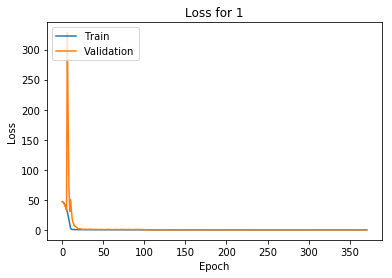

1-1 -1.2843869548179039

Epoch 00150: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00220: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00283: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00331: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00341: early stopping


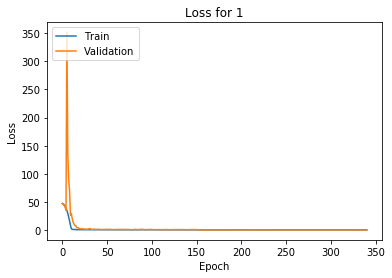

1-2 -1.395786538729541

Epoch 00078: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00138: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00334: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00344: early stopping


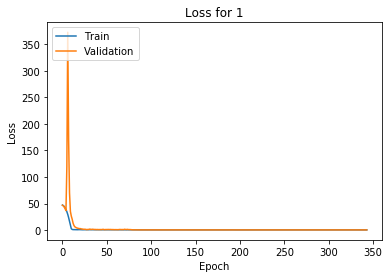

1-3 -1.3103910588820031

Epoch 00101: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00215: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00414: early stopping


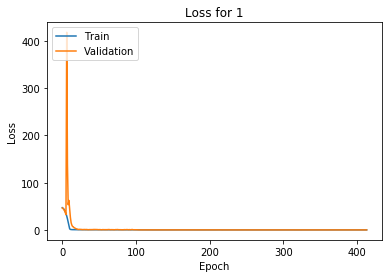

1-4 -1.3395922694916733

Epoch 00108: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00162: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00396: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00440: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00450: early stopping


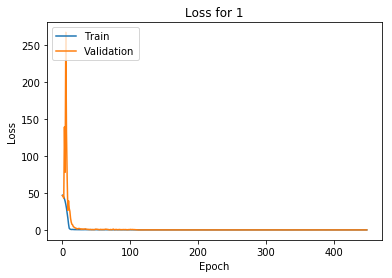

1-5 -1.28415615638019

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00112: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00386: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00459: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00469: early stopping


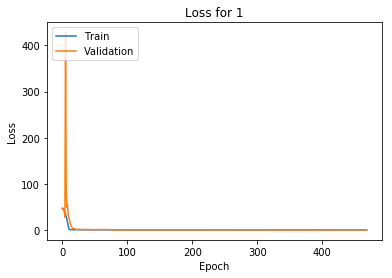

1-6 -1.3061002810906874

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00174: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00243: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00253: early stopping


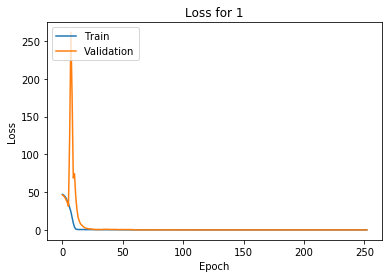

1-7 -1.2172511433342632
Training 4 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00141: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00204: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00260: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00293: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00337: early stopping


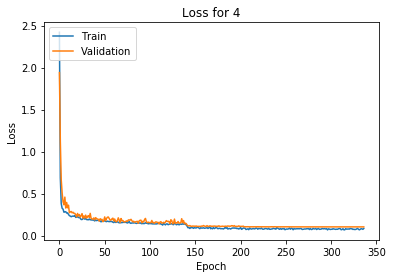

4-0 -2.2745113941957475

Epoch 00126: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00165: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00238: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00274: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00284: early stopping


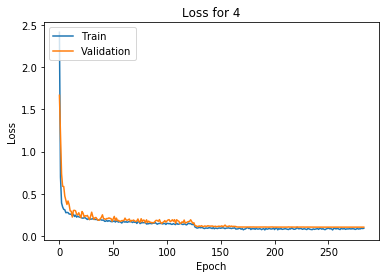

4-1 -2.261234296454839

Epoch 00223: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00309: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00345: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00378: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00388: early stopping


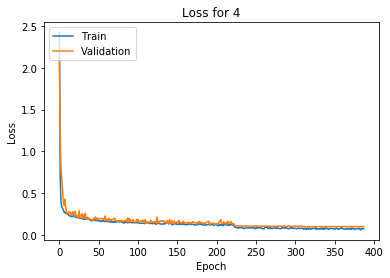

4-2 -2.322085844676287

Epoch 00202: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00288: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00357: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00399: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00409: early stopping


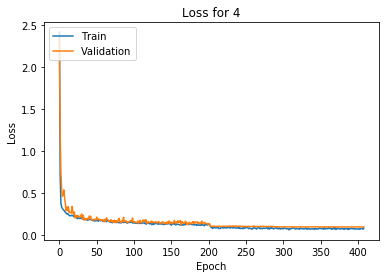

4-3 -2.3498552509037993

Epoch 00226: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00284: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00346: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00379: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00429: early stopping


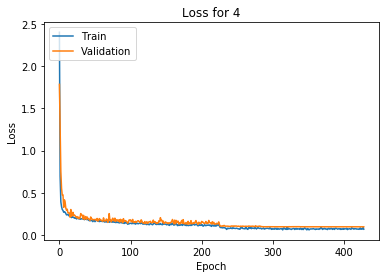

4-4 -2.311088467920092

Epoch 00220: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00315: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00364: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00419: early stopping


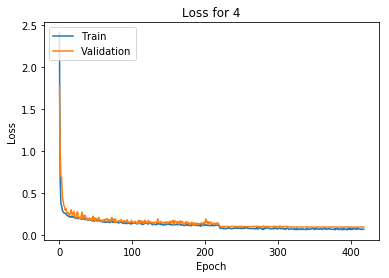

4-5 -2.337023577544816

Epoch 00158: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00236: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00312: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00355: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00365: early stopping


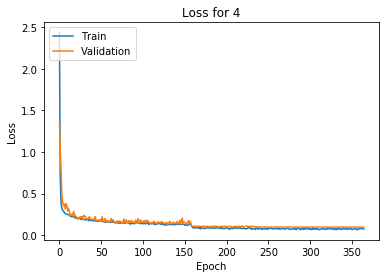

4-6 -2.326843917249653

Epoch 00151: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00196: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00264: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00300: ReduceLROnPlateau reducing learning rate to 1e-06.
Restoring model weights from the end of the best epoch
Epoch 00341: early stopping


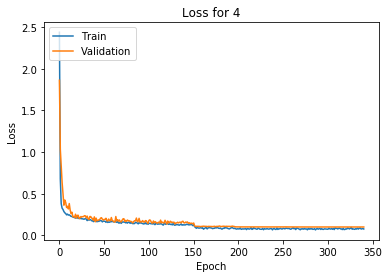

4-7 -2.2940252408036597
Training 2 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00228: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00299: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00352: early stopping


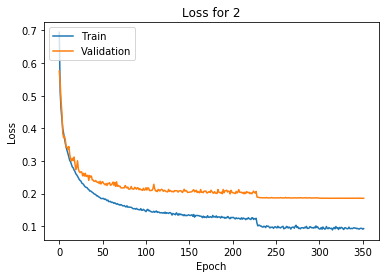

2-0 -1.6834376073269481

Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00339: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00349: early stopping


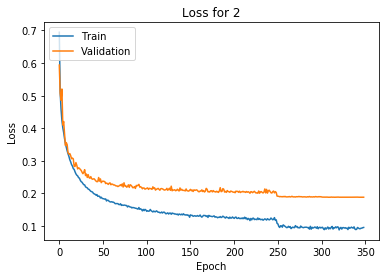

2-1 -1.668800600438625

Epoch 00325: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00368: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00408: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00418: early stopping


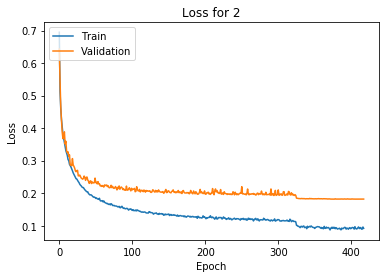

2-2 -1.7052235930030446

Epoch 00269: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00334: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00372: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00382: early stopping


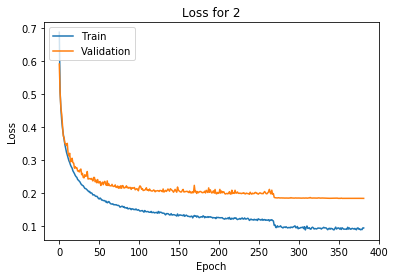

2-3 -1.6894881165580353

Epoch 00157: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00215: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00289: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00299: early stopping


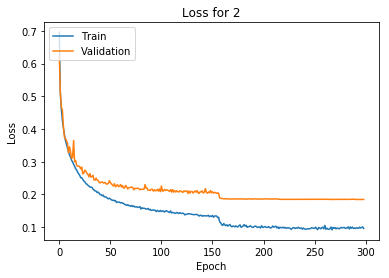

2-4 -1.688849450654171

Epoch 00289: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00382: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00392: early stopping


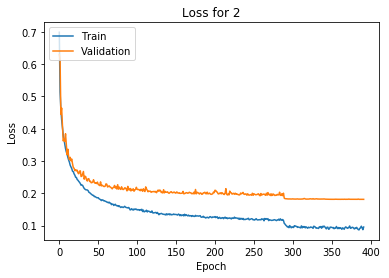

2-5 -1.7077806485608862

Epoch 00413: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00456: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00506: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00516: early stopping


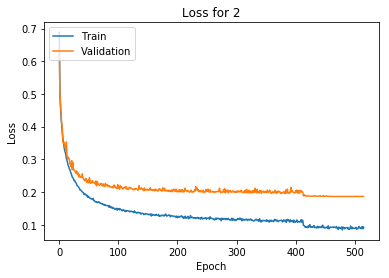

2-6 -1.6806569058874374

Epoch 00242: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00288: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00328: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00338: early stopping


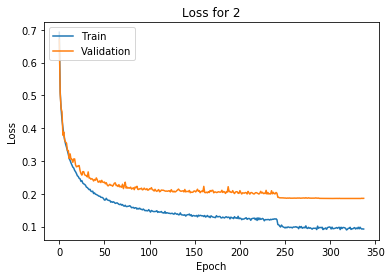

2-7 -1.6840750147041978
Training 6 out of [0, 3, 1, 4, 2, 6, 5, 7] 


Epoch 00206: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00290: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00369: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00379: early stopping


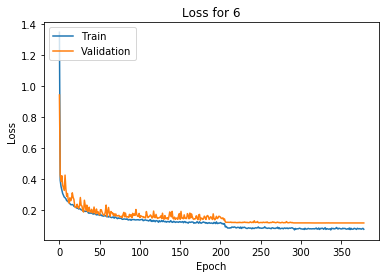

6-0 -2.1682845234502017

Epoch 00212: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00301: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00342: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00352: early stopping


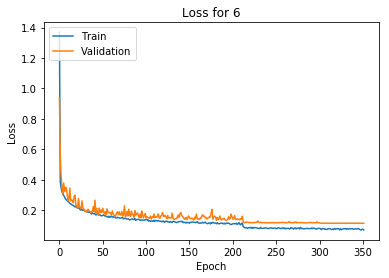

6-1 -2.1646323445831235

Epoch 00219: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00357: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00409: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Restoring model weights from the end of the best epoch
Epoch 00419: early stopping


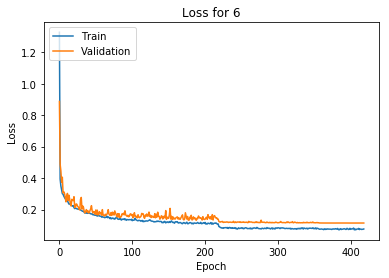

6-2 -2.170023455835229

Epoch 00188: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


In [ ]:


start_time=datetime.now()
# test_prediction=np.zeros(len(test_csv))
test_predict_list = {}


his = []
# Loop through each molecule type
for mol_type in type_list:

    model_name_wrt = ('molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', type_list, '\n')
    
    df_train_i = df_train[df_train['type']==mol_type][type_columns[mol_type]]
    df_test_i = df_test[df_test['type']==mol_type][type_columns[mol_type]]
    
#     full = build_couple_dataframe(train_csv, structures_csv, mol_type, n_atoms=11)
#     full2 = build_couple_dataframe(test_csv, structures_csv, mol_type, n_atoms=11)
#     df_train_ = take_n_atoms(full, 11)
#     df_test_ = take_n_atoms(full2, 11)
#     df_train_  = df_train_.fillna(0)
#     df_test_  = df_test_.fillna(0)
    
#     # Standard Scaler from sklearn does seem to work better here than other Scalers
#     input_data=StandardScaler().fit_transform(pd.concat([df_train_.loc[:,input_features],df_test_.loc[:,input_features]]))   
#     #input_data=StandardScaler().fit_transform(df_train_.loc[:,input_features])
#     target_data=df_train_.loc[:,"scalar_coupling_constant"].values
    
    input_data=StandardScaler().fit_transform(pd.concat([df_train_i,  df_test_i]))
    X_train = input_data[:len(df_train_i),:]
    y_train =df_train[df_train['type']==mol_type]["scalar_coupling_constant"].values
    X_test = input_data[len(df_train_i):,:]
    group = df_train[df_train['type']==mol_type].group
    
    
    # Simple split to provide us a validation set to do our CV checks with
#     train_index, cv_index = train_test_split(np.arange(len(df_train_i)),random_state=111, test_size=0.2)

    group_kfold = GroupKFold(n_splits=8)
    for n_fold, (train_index, cv_index) in enumerate(group_kfold.split(X_train, y_train, group)):
        
        # Split all our input and targets by train and cv indexes
        train_target=y_train[train_index]
        cv_target=y_train[cv_index]
        train_input=X_train[train_index]
        cv_input=X_train[cv_index]
    
        # Build the Neural Net
        nn_model=create_nn_model(train_input.shape[1])
    
        # If retrain==False, then we load a previous saved model as a starting point.
        if not retrain:
            nn_model = load_model(model_name_rd)

        nn_model.compile(loss='mae', optimizer=Adam())#, metrics=[auc])

        # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
        es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=40,verbose=1, mode='auto', restore_best_weights=True)
        # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
        rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=30, min_lr=1e-6, mode='auto', verbose=1)
        # Save the best value of the model for future use
        sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
        history = nn_model.fit(train_input,[train_target], 
                validation_data=(cv_input,[cv_target]), 
                callbacks=[es, rlr, sv_mod], epochs=epoch_n, batch_size=batch_size, verbose=verbose)

        cv_predict=nn_model.predict(cv_input)
        plot_history(history, mol_type)
        accuracy=np.mean(np.abs(cv_target-cv_predict[:,0]))
        print(f'{mol_type}-{n_fold}', np.log(accuracy))
        cv_score.append(np.log(accuracy))
        cv_score_total+=np.log(accuracy)

        # Predict on the test data set using our trained model
        test_predict=nn_model.predict(X_test)

        # for each molecule type we'll grab the predicted values
#         test_predict_list[mol_type] = test_predict
    #     test_csv[test_csv["type"]==mol_type]=test_predict[:,0]
    
        his.append({'type':mol_type, 'nfold':n_fold, 'cv_index':cv_index, 'test_predict':test_predict, 'cv_predict':cv_predict})
        K.clear_session()
#     break
#     break

# cv_score_total/=len(mol_types)

In [62]:
valid_list = {0:-0.7333170030838179,
3:-2.4540746391087085,
1:-1.3474818937693096,
4:-2.2891633097476864,
2:-1.6972980093917749,
6:-2.137732236123424,
5:-1.6694864546861885,
7:-2.3854512965185575}

In [65]:
valid_mae = 0
for k, v in valid_list.items():
    valid_mae += np.exp(v)
valid_mae /= len(valid_list)

In [66]:
valid_mae

0.18862398603738667

In [49]:
df_submission = pd.DataFrame()
for k,v in test_predict_list.items():
    df_test_i = df_test[df_test['type']==k]
    df_test_i['pred'] = v
    df_submission = pd.concat([df_submission, df_test_i], axis=0)
df_submission = df_submission.reset_index(drop=True)
df_submission = df_submission[['index','pred']]
df_submission = df_submission.sort_values(by=['index'])
df_submission = df_submission.reset_index(drop=True)
df_submission = df_submission.rename(columns = {'index':'id','pred':'scalar_coupling_constant'})

In [67]:
idx=0.18
df_submission.to_csv('../../data/submission/submission_mpnn_{}.csv'.format(idx), index=False)
print(df_submission.shape)
df_submission.tail()


(2505542, 2)


,id,scalar_coupling_constant
2505537,7163684,0.668318
2505538,7163685,3.036620
2505539,7163686,1.965160
2505540,7163687,4.334040
2505541,7163688,117.560974
